In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate

from IPython.display import HTML
from IPython.display import clear_output

In [44]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
total_iteration = 1000
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size = 1000
dataloader = torch.utils.data.DataLoader(Cluster2DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

## Real Samples

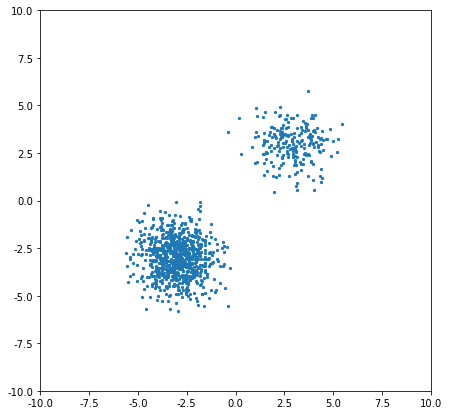

In [47]:
scatter(next(iter(dataloader)), True)

In [48]:
scatter_range = [-10, 10]
total_iteration = 2000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True

In [49]:
learning_rate = 5e-3
z_dim = 2
sample_dir = './results/clusters2'
lamd = 5000

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Traning VAE

In [50]:
model = VAE(input_size=2, h_dim=256, z_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
torch.multiprocessing.set_start_method('spawn', force=True)
# Start training
for i in range(total_iteration):
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)

    x_reconst, mu, log_var = model(data)

    # Compute reconstruction loss and kl divergence
    # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
    # reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
    reconst_loss = F.mse_loss(x_reconst, data)
    kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Backprop and optimize
    loss = lamd*reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print("Iteration[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                .format(i+1, total_iteration, reconst_loss.item(), kl_div.item()))

        with torch.no_grad():
            # Save the sampled images
            z = torch.randn(batch_size, z_dim).to(device)
            out = model.decode(z)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(i+1)))
            # Save the reconstructed images
            out, _, _ = model(data)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(i+1)))
            plt.close('all')

Iteration[100/2000], Reconst Loss: 0.1986, KL Div: 2888.9895
Iteration[200/2000], Reconst Loss: 0.1939, KL Div: 2709.8232
Iteration[300/2000], Reconst Loss: 0.2031, KL Div: 2537.4663
Iteration[400/2000], Reconst Loss: 0.2217, KL Div: 2424.3564
Iteration[500/2000], Reconst Loss: 0.1954, KL Div: 2488.3901
Iteration[600/2000], Reconst Loss: 0.2155, KL Div: 2400.6616
Iteration[700/2000], Reconst Loss: 0.2108, KL Div: 2344.3821
Iteration[800/2000], Reconst Loss: 0.2224, KL Div: 2351.2549
Iteration[900/2000], Reconst Loss: 0.2178, KL Div: 2453.8738
Iteration[1000/2000], Reconst Loss: 0.1947, KL Div: 2423.0627
Iteration[1100/2000], Reconst Loss: 0.2472, KL Div: 2263.5881
Iteration[1200/2000], Reconst Loss: 0.1830, KL Div: 2405.5337
Iteration[1300/2000], Reconst Loss: 0.1918, KL Div: 2401.9858
Iteration[1400/2000], Reconst Loss: 0.2054, KL Div: 2370.7407
Iteration[1500/2000], Reconst Loss: 0.2125, KL Div: 2321.2864
Iteration[1600/2000], Reconst Loss: 0.2159, KL Div: 2332.3181
Iteration[1700/20